In [ ]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
!unzip /content/drive/MyDrive/Celeb-DF.zip > /dev/null

In [ ]:
import os
import cv2
import dlib

def extract_faces(video_path, output_folder, is_real=True):
    detector = dlib.get_frontal_face_detector()

    output_folder_faces = os.path.join(output_folder, 'real' if is_real else 'fake')
    os.makedirs(output_folder_faces, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    frameRate = cap.get(5)
    frameId = 0

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frameId += 1
        if frameId % ((int(frameRate) + 1) * 1) == 0:
            face_rects, _, _ = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1, y1, x2, y2 = d.left(), d.top(), d.right(), d.bottom()
                crop_img = frame[y1:y2, x1:x2]
                if not crop_img.size==0:
                    resized=cv2.resize(crop_img,(256,256))
                    output_path = os.path.join(output_folder_faces, f"frame_{frameId}face{i}.png")
                    cv2.imwrite(output_path, resized)

    cap.release()

celeb_real_folder = '/content/Celeb-real'
celeb_fake_folder = '/content/Celeb-synthesis'
output_folder = '/content/datamining3'

list_of_real_data = [f for f in os.listdir(celeb_real_folder) if f.endswith('.mp4')]
for vid in list_of_real_data:
    extract_faces(os.path.join(celeb_real_folder, vid), output_folder, is_real=True)

list_of_fake_data = [f for f in os.listdir(celeb_fake_folder) if f.endswith('.mp4')]
for vid in list_of_fake_data:
    extract_faces(os.path.join(celeb_fake_folder, vid), output_folder, is_real=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
!unzip /content/drive/MyDrive/imgs.zip > /dev/null

In [ ]:
image_dimensions = {'height':256, 'width':256, 'channels':3}
class Classifier:
    def __init__():
        self.model = 0

    def predict(self, x):
        return self.model.predict(x)

    def fit(self, x, y):
        return self.model.train_on_batch(x, y)

    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)

    def load(self, path):
        self.model.load_weights(path)

In [ ]:
class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])

    def init_model(self):
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))

        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [ ]:
class MesoInception4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    def InceptionLayer(self, a, b, c, d):
        def func(x):
            x1 = Conv2D(a, (1, 1), padding='same', activation='relu')(x)

            x2 = Conv2D(b, (1, 1), padding='same', activation='relu')(x)
            x2 = Conv2D(b, (3, 3), padding='same', activation='relu')(x2)

            x3 = Conv2D(c, (1, 1), padding='same', activation='relu')(x)
            x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='relu')(x3)

            x4 = Conv2D(d, (1, 1), padding='same', activation='relu')(x)
            x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='relu')(x4)

            y = Concatenate(axis = -1)([x1, x2, x3, x4])

            return y
        return func

    def init_model(self):
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        x1 = self.InceptionLayer(1, 4, 4, 2)(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = self.InceptionLayer(2, 4, 4, 2)(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [ ]:
meso = Meso4()
meso.load('/content/Meso4_DF.h5')

In [ ]:
dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
    '/content/Dataset/Test',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 10905 images belonging to 2 classes.


In [ ]:
generator.class_indices

{'Fake': 0, 'Real': 1}

1/1 [==============================] - 0s 46ms/step
Predicted likelihood: 0.9470
Actual label: 0
1/1 [==============================] - 0s 46ms/step

Correct prediction: False


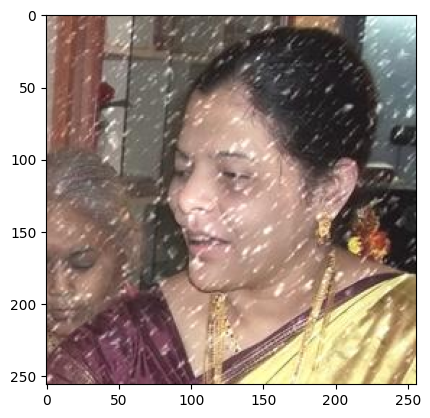

In [ ]:
X, y = generator.next()
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")
plt.imshow(np.squeeze(X));

In [ ]:
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [ ]:
for i in range(len(generator.labels)):
    X, y = generator.next()
    pred = meso.predict(X)[0][0]
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)
    if i % 1000 == 0:
        print(i, ' predictions completed.')

    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 51ms/step
6000  predictions completed.
1/1 [==============================] - 0s 35ms/step
7000  predictions completed.
1/1 [==============================] - 0s 30ms/step
8000  predictions completed.
1/1 [==============================] - 0s 63ms/step
9000  predictions completed.
1/1 [==============================] - 0s 35ms/step
10000  predictions completed.
1/1 [==============================] - 0s 37ms/step
All 10905 predictions completed


In [ ]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

4143

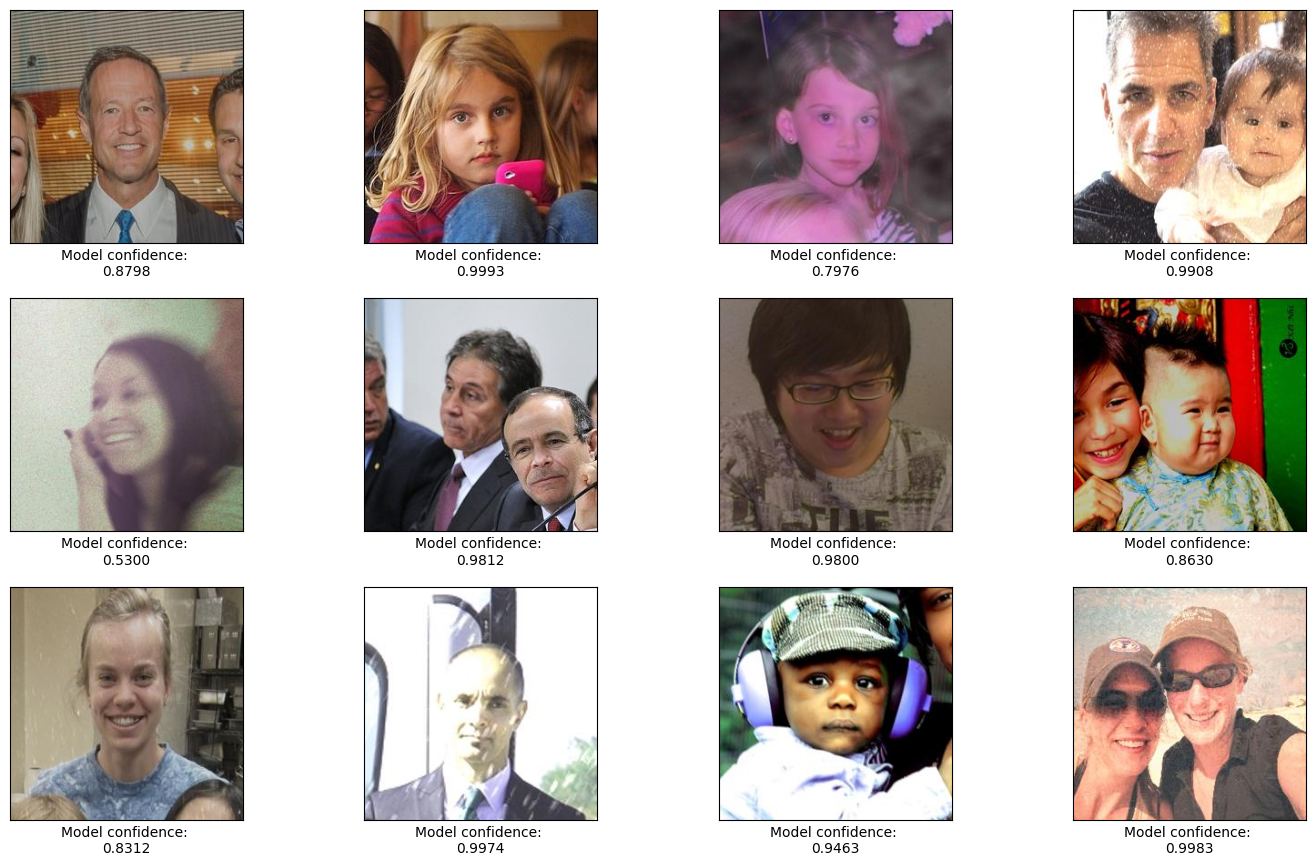

In [ ]:
plotter(correct_real, correct_real_pred)
len(correct_real)

1270

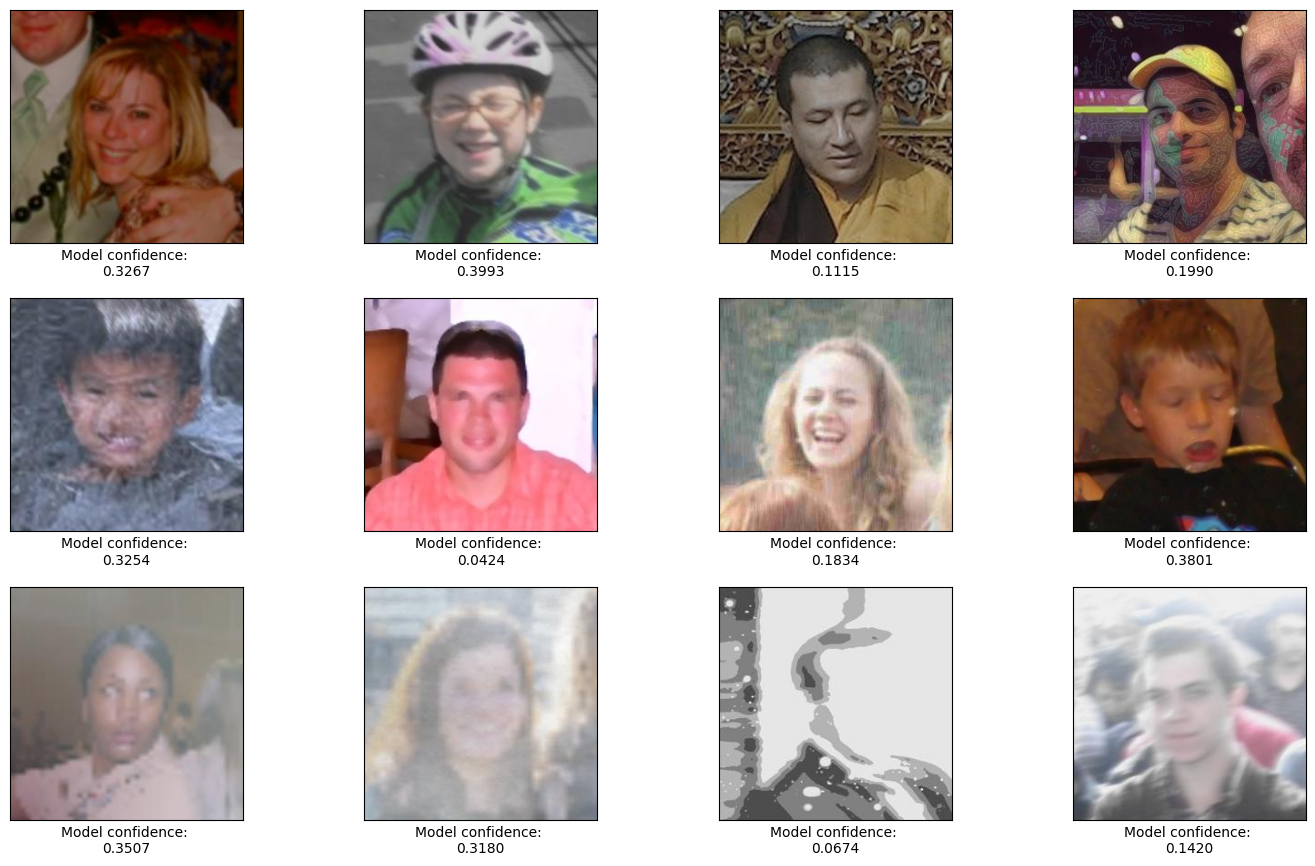

In [ ]:
plotter(misclassified_real, misclassified_real_pred)
len(misclassified_real_pred)

4310

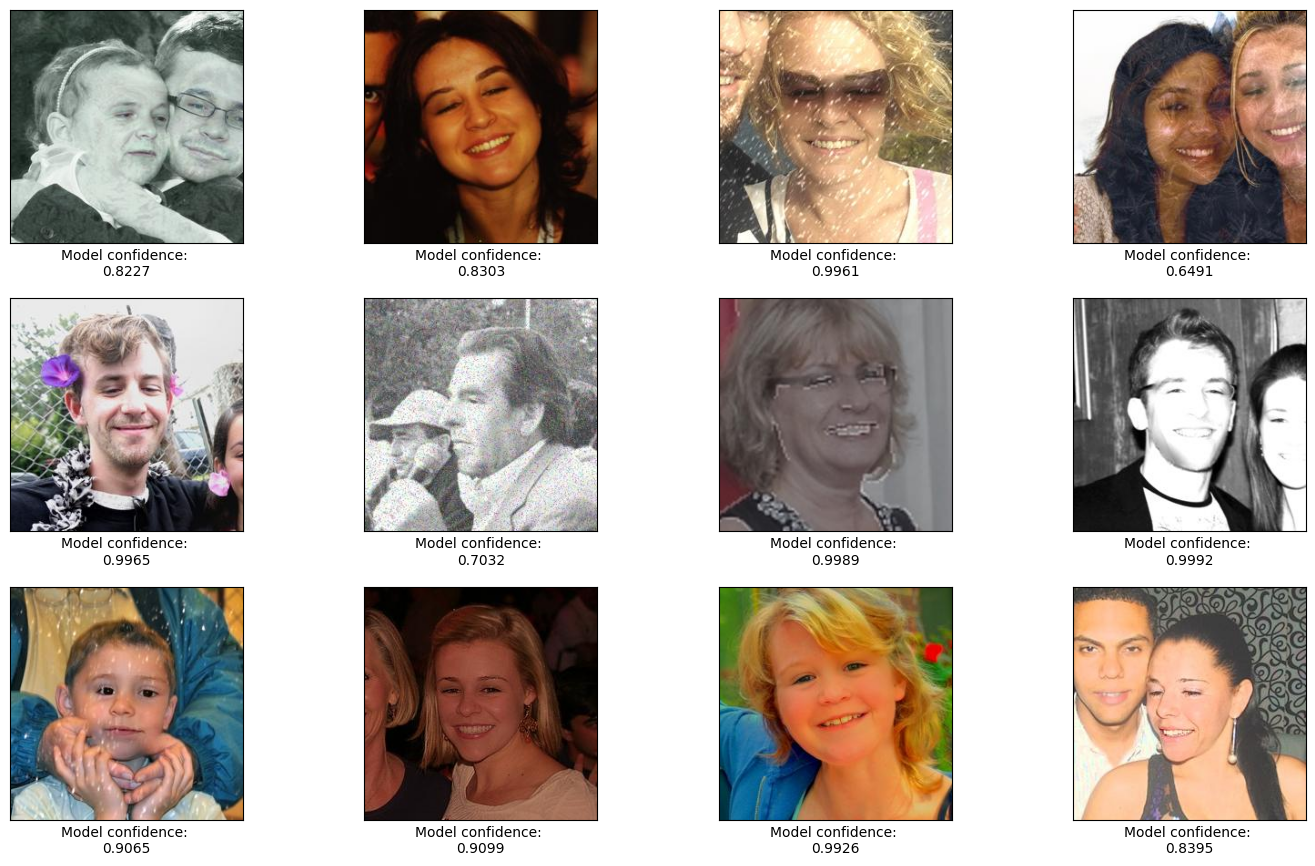

In [ ]:
plotter(correct_deepfake, correct_deepfake_pred)
len(correct_deepfake_pred)

1182

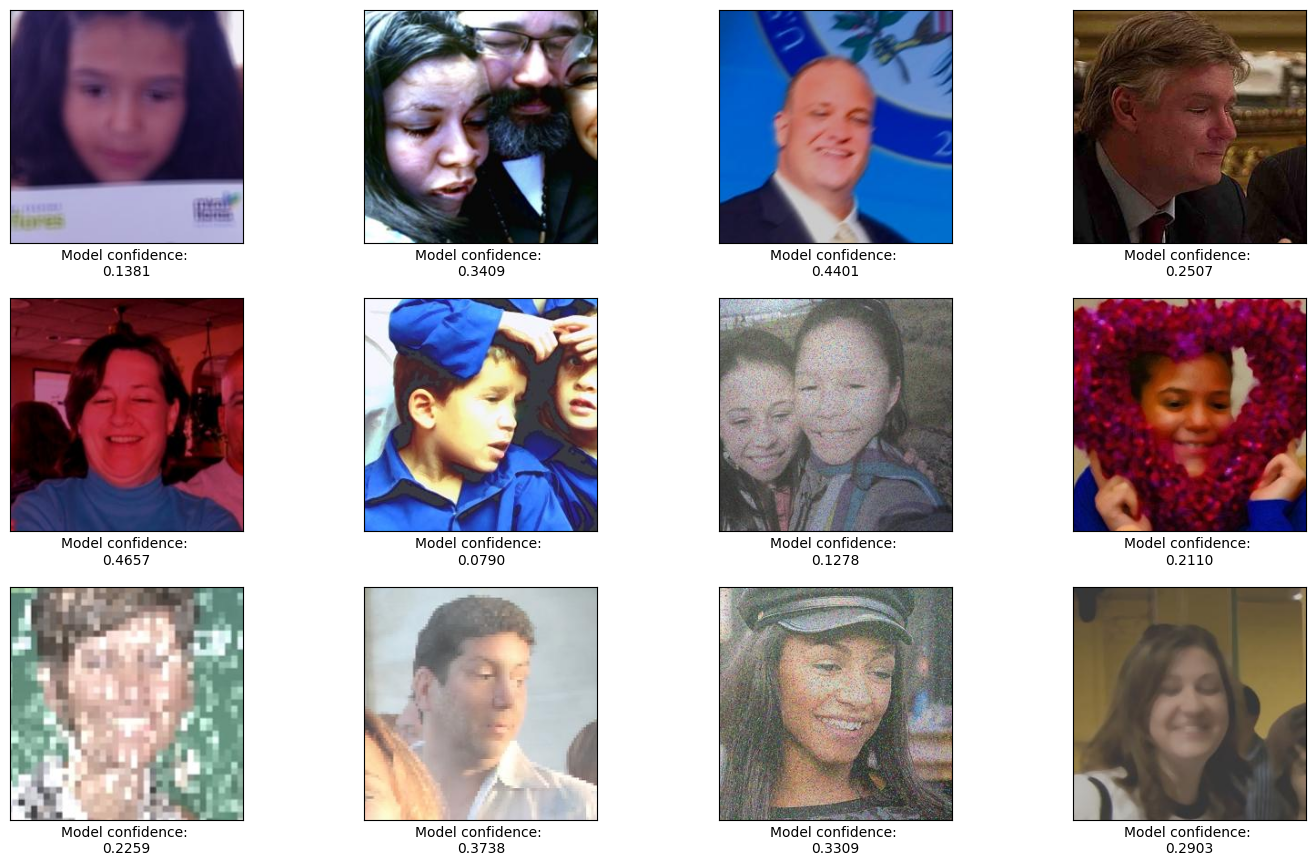

In [ ]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)
len(misclassified_deepfake_pred)